<b><font size="5">Random Tree Regression</font></b>

First we start by importing our liberaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score

Then we load and inspect our Data

In [2]:
df = pd.read_csv(r"..\data\sample_ml_data_75000.csv")
display(df.info())
display(df.describe().T)
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Product_Code      75000 non-null  int64
 1   Warehouse         75000 non-null  int64
 2   Product_Category  75000 non-null  int64
 3   Open              75000 non-null  int64
 4   Promo             75000 non-null  int64
 5   StateHoliday      75000 non-null  int64
 6   SchoolHoliday     75000 non-null  int64
 7   Petrol_price      75000 non-null  int64
 8   High_Demand       75000 non-null  int64
dtypes: int64(9)
memory usage: 5.1 MB


None

,count,mean,std,min,25%,50%,75%,max
Product_Code,75000.0,1033.671600,566.202755,0.0,585.0,1166.0,1420.0,2047.0
Warehouse,75000.0,1.662080,0.767909,0.0,2.0,2.0,2.0,3.0
Product_Category,75000.0,11.222293,7.884654,0.0,2.0,16.0,16.0,29.0
Open,75000.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Promo,75000.0,0.469947,0.499099,0.0,0.0,0.0,1.0,1.0
StateHoliday,75000.0,0.001520,0.038958,0.0,0.0,0.0,0.0,1.0
SchoolHoliday,75000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Petrol_price,75000.0,88.005120,4.907611,80.0,84.0,88.0,92.0,96.0
High_Demand,75000.0,0.494067,0.499968,0.0,0.0,0.0,1.0,1.0


,Product_Code,Warehouse,Product_Category,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price,High_Demand
0,1269,2,16,1,1,0,0,85,1
1,1441,2,16,1,0,0,0,80,1
2,1295,2,16,1,1,0,0,93,1
3,1141,2,16,1,0,0,0,95,1
4,982,2,4,1,0,0,0,93,1


<b><font size="5">Feature Engineering</font></b>

Date shows the date of the last product count. We can change this to an attribute, to show the day, month, and year as numerical values

# Convert date to datetime - using the correct format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Changed format
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

#Drop the old Date column
df.drop(columns="Date", inplace=True)

display(df.head())

We can also drop other columns that does not affect the ouput. The first three columns have the same value for all records, and StudentID is just an identifier

In [3]:
df.drop(columns=['Open', 'SchoolHoliday',],inplace=True)
display(df.head())

,Product_Code,Warehouse,Product_Category,Promo,StateHoliday,Petrol_price,High_Demand
0,1269,2,16,1,0,85,1
1,1441,2,16,0,0,80,1
2,1295,2,16,1,0,93,1
3,1141,2,16,0,0,95,1
4,982,2,4,0,0,93,1


Now we can find our categorical, and numerical features

In [4]:
output_var = 'High_Demand'
numeric_data = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_data if col != output_var]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Numeric Features    : {numeric_features}')
print(f'Categorical Features: {categorical_features}')

Numeric Features    : ['Product_Code', 'Warehouse', 'Product_Category', 'Promo', 'StateHoliday', 'Petrol_price']
Categorical Features: []


**Numerical Data Engineering**

Now we can visualize our Numerical Data

plt.figure(figsize=(8, 4))
for i, col in enumerate(df[numeric_features].columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

This data seems very seasonal. We can test for skewness using the skewness coefficient. We see that no skewness coefficient is over 1

In [5]:
for col in numeric_data:
    print(f'{col} = {df[col].skew()}')

Product_Code = -0.19112473619496223
Warehouse = -1.433598589290207
Product_Category = -0.09983296975917293
Promo = 0.12043348624522568
StateHoliday = 25.591452790684396
Petrol_price = -0.008079774268644464
High_Demand = 0.023735479259690096


Now we can generate box-plots of our features

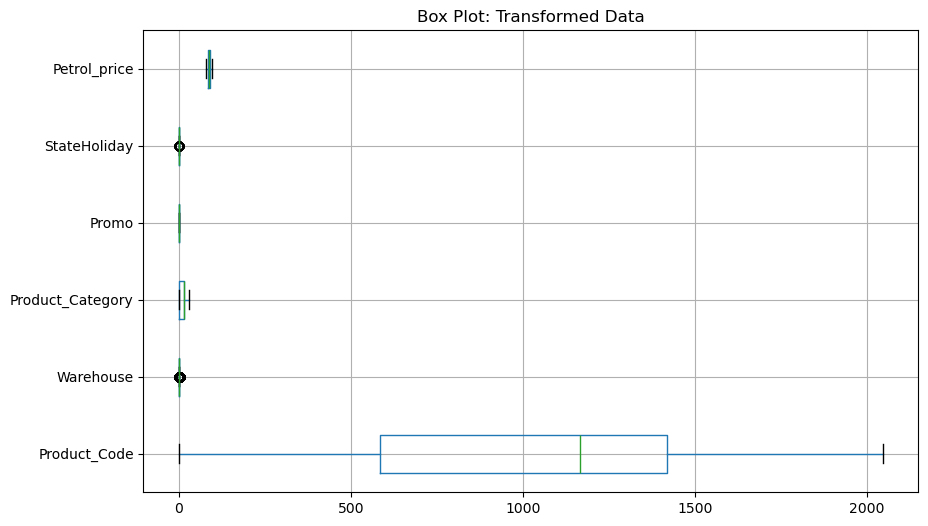

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

We can apply slight scaling to all numeric data. We can use the minmax scaler to scale the values of all features to fit between 0 and 1 to fit with our promo values

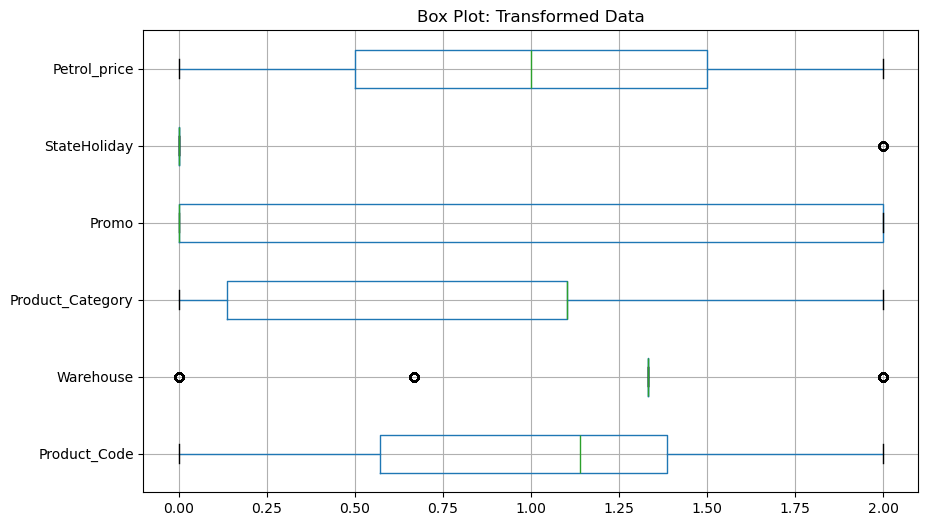

In [7]:
scaler = MinMaxScaler(feature_range=(0, 2))
scaler.fit(df[numeric_features])

df[numeric_features] = scaler.transform(df[numeric_features])

fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

**Categorical Data Engineering**

In [8]:
print(f'Categorical Features: {categorical_features}')

Categorical Features: []


We can encode values to our categorical data

In [9]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['Product_Code', 'Warehouse', 'Product_Category']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

View our correlation coefficients

In [10]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

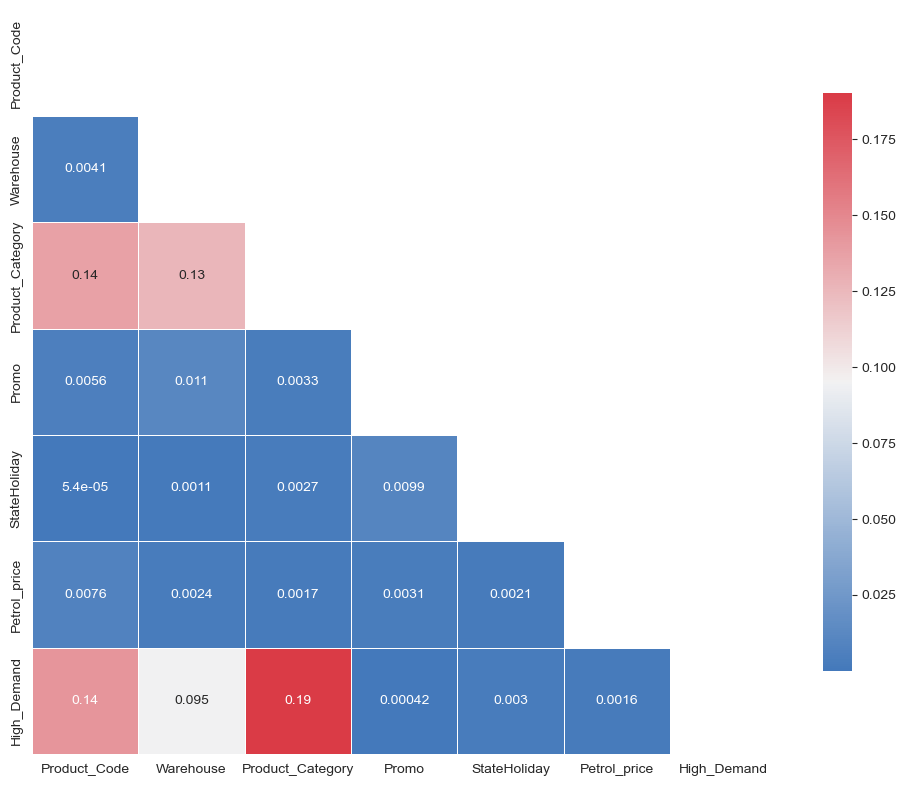

In [11]:
CorrPlot(df, figsize = (12, 10))

Extract features and define input and output variables

In [12]:
features = df.columns.drop(output_var).to_list()
X = df[features]
Y = df[output_var]
display(X, Y)

,Product_Code,Warehouse,Product_Category,Promo,StateHoliday,Petrol_price
0,1262,2,16,2.0,0.0,0.625
1,1433,2,16,0.0,0.0,0.000
2,1287,2,16,2.0,0.0,1.625
3,1134,2,16,0.0,0.0,1.875
4,975,2,4,0.0,0.0,1.625
...,...,...,...,...,...,...
74995,918,0,3,0.0,0.0,0.375
74996,1363,2,16,2.0,0.0,0.000
74997,125,0,18,0.0,0.0,1.125
74998,1284,2,16,0.0,0.0,0.125


0        1
1        1
2        1
3        1
4        1
        ..
74995    0
74996    1
74997    0
74998    1
74999    1
Name: High_Demand, Length: 75000, dtype: int64

Now we can split our data into testing and training sets

In [13]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

<b><font size="5">Machine Model Training</font></b>

**Random Forrest Classification**

In [14]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier()

In [15]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

In [16]:
train_accuracy = accuracy_score(Y_train, Y_train_pred)
print(f'Train Accuracy: {np.round(100*train_accuracy, 1)}%')

Train Accuracy: 92.4%


In [17]:
test_accuracy = accuracy_score(Y_test, Y_test_pred)
print(f'Test Accuracy: {np.round(100*test_accuracy, 1)}%')

Test Accuracy: 82.0%


In [18]:
train_mae = np.round(mean_absolute_error(Y_train, Y_train_pred), 3)#The ,3 is just to 3 decimal places
train_mse = np.round(mean_squared_error(Y_train, Y_train_pred), 3)
train_rmse = np.round(np.sqrt(train_mse), 3)

print(f"Comparisons of Metrics - TRAINING DATA")
print(f"Training MAE - {train_mae}")
print(f"Training MSE - {train_mse}")
print(f"Training RMSE - {train_rmse}") 
print()

test_mae = np.round(mean_absolute_error(Y_test, Y_test_pred), 3)#The ,3 is just to 3 decimal places
test_mse = np.round(mean_squared_error(Y_test, Y_test_pred), 3)
test_rmse = np.round(np.sqrt(test_mse), 3)

print(f"Comparisons of Metrics - TESTING DATA")
print(f"Training MAE - {test_mae}")
print(f"Training MSE - {test_mse}")
print(f"Training RMSE - {test_rmse}") 

Comparisons of Metrics - TRAINING DATA
Training MAE - 0.076
Training MSE - 0.076
Training RMSE - 0.276

Comparisons of Metrics - TESTING DATA
Training MAE - 0.18
Training MSE - 0.18
Training RMSE - 0.424


In [19]:
from sklearn.metrics import classification_report
print("Random Forrest Report:\n", classification_report(Y_test, Y_test_pred))

Random Forrest Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     11349
           1       0.81      0.83      0.82     11151

    accuracy                           0.82     22500
   macro avg       0.82      0.82      0.82     22500
weighted avg       0.82      0.82      0.82     22500

